In [1]:
# This notebook creates spectrogram images from a directory of sound files in .wav format.
# The code is optimized to be processed in parallel on multi-core machines.

In [1]:
# Spectogram generation library
# https://librosa.org/doc/latest/index.html
# import sys
# !conda install --yes --prefix {sys.prefix} librosa


In [2]:
# imports

# With the exception of the librosa library installed above, all of these modules are 
# either included in the code base or provided by default on Amazon Sagemaker. 

import gc
import glob
import multiprocessing as mp
import pprint
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
from db import NABat_DB


In [3]:
import db_handler

In [4]:
# Test we have a valid database and enumerate the species represented.
db = NABat_DB(p="db_test_20230911")
species = db.query(' select * from species;')
pprint.pprint(species)
db.conn.close()


[Row(id=1, species_code='ANPA', common_name='Pallid bat', min_frequency=27000, max_frequency=51000, available=1),
 Row(id=2, species_code='CHME', common_name='Mexican long-tongued bat', min_frequency=4999, max_frequency=99999, available=1),
 Row(id=3, species_code='CORA', common_name="Rafinesque's big-eared bat", min_frequency=4999, max_frequency=99999, available=1),
 Row(id=4, species_code='COTO', common_name="Townsend's big-eared bat", min_frequency=22000, max_frequency=41000, available=1),
 Row(id=5, species_code='EPFU', common_name='Big brown bat', min_frequency=25000, max_frequency=52000, available=1),
 Row(id=6, species_code='EUMA', common_name='Spotted bat', min_frequency=10000, max_frequency=17000, available=1),
 Row(id=7, species_code='EUFL', common_name='Florida bonneted bat', min_frequency=10000, max_frequency=25000, available=1),
 Row(id=8, species_code='EUPE', common_name='Greater mastiff bat', min_frequency=10000, max_frequency=19000, available=1),
 Row(id=9, species_code

In [5]:
# Point to a directory containing .wav files organized by species code. 
# Example "../v1.1.0/data/wav/ANPA/p163_g89522_f28390444.wav"
# directory = '../Downloads/data/wav'
directory = "/Volumes/sd4tb_1/NABat/data/wav"

Median files per class:  182.0


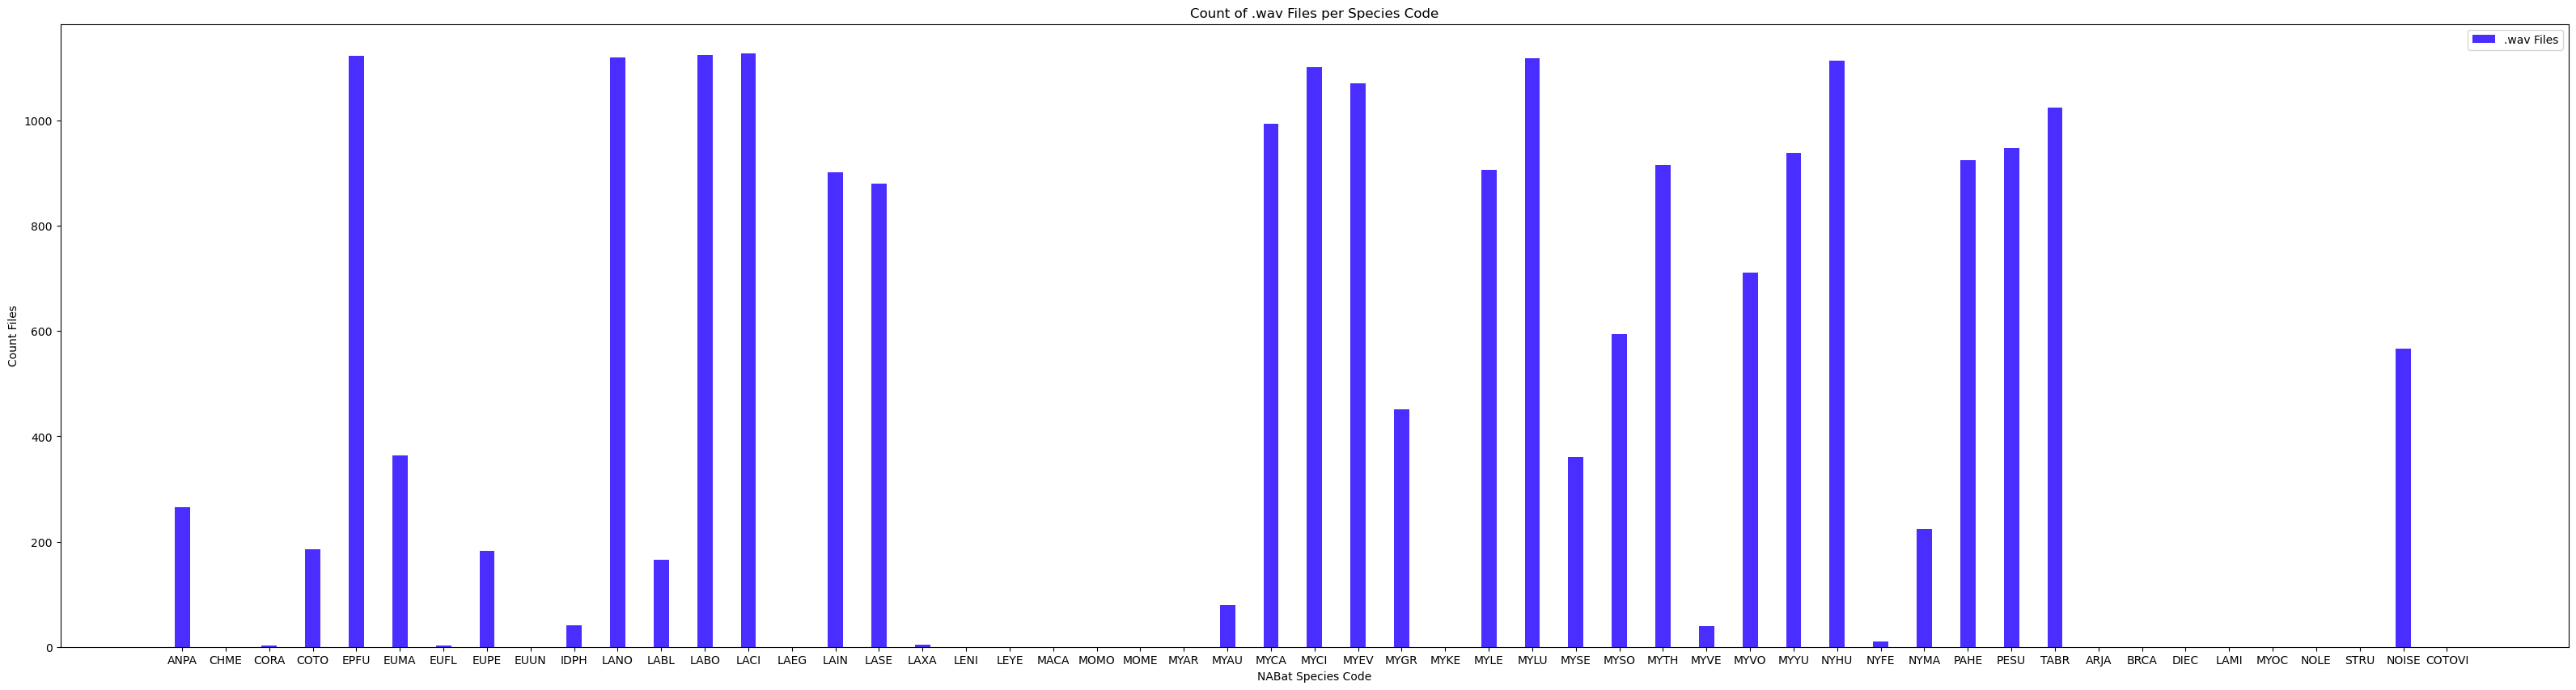

In [6]:
# Optional step.
# Create a plot visualizing our sample size of input data.

plt.close(fig='all')
class_names = []
wav_count = []
for s in species:
    class_names.append(s[1])
    wav_count.append(len(glob.glob('{}/{}/*.wav'.format(directory,s[1]), recursive=True)))

figure = plt.figure(figsize=(40, 10))

labels = class_names
count = np.array(wav_count)
print('Median files per class: ', np.median(count)//1)

width = 0.35 # the width of the bars: can also be len(x) sequence

plt.bar(labels, count, width, color="#4a2eff", label='.wav Files')

plt.ylabel('Count Files')
plt.xlabel('NABat Species Code')

plt.title('Count of .wav Files per Species Code')
plt.legend()
plt.show()


In [7]:
# Use as many threads as we can, leaving one available to keep notebook responsive.
thread_count = (mp.cpu_count() - 2)
print('using {} threads'.format(thread_count))
 
# Gather wav files.
files = glob.glob('{}/**/*.wav'.format(directory), recursive=True)
progress = int(len(files) * 0.01)

using 8 threads


In [8]:
len(files), progress

(21586, 215)

In [9]:
# Test out db_handler.process_file
# idx_file = 10
# print(files[idx_file])
# db_handler.process_file(file=files[idx_file], db_name="db_test_20230911")

In [12]:
# Start the creation process in parallel and report progress.
for i in range(0,len(files),progress):
    with Pool(thread_count) as p:
        p.map(db_handler.process_file, files[i:i+progress])
        gc.collect()
        print('{}%'.format(int(i/progress)))


TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
# Done!